# BAGLE: Model Fitting Tutorial
### This Jupyter Notebook tutorial introduces how to model fit different microlensing events with the BAGLE model fitting functions. To read full docs, go [here](https://bagle.readthedocs.io/en/latest/PSPL_Solver.html#model_fitter.PSPL_Solver). To learn how to use BAGLE's model function, look at [this tutorial](https://github.com/MovingUniverseLab/BAGLE_Microlensing/blob/main/BAGLE_TUTORIAL.ipynb).
By default, BAGLE uses a MultiNest sampling algorithm (a nested-sampling alternative to MCMC) with observed data to generate samples from posterior distributions.

## Import modules

In the general BAGLE model tutorial, we only needed to import model.py. For the case of model fitting, we will need to import the model.py function along with the model_fitter.py. 

<div class="alert alert-block alert-warning">
    <b>Note:</b> For the sake of this tutorial, we will be using fake data based on a real microlensing event. Using this fake data involves importing the fake_data.py file as well. For personal uses, you will not use fake_data.
</div>

In [8]:
from bagle import model, model_fitter, fake_data

Importing the ability to see images and os (to create directories in your base directory to put the output files):

<div class="alert alert-block alert-warning">
    <b>Note:</b> The below modules will not be necessary when using the fitter. This is only used for the tutorial. Additionally, the make directory are used to signify where the output data and plots will go for this tutorial. Normal usages of the fitter will not necessarily need that code.
</div>

In [9]:
from astropy.table import Table
import numpy as np
import os
from PIL import Image
from IPython.display import display
''' 
instead of the usual way of using markdown for images, viewing the images is coded in so that if changes are made
to the code by the user, running the code for the images will reflect these changes.
'''
os.makedirs('fit_files', exist_ok=True)
os.makedirs('astrom_test_files', exist_ok=True)

### Import / generate your data

In any case when modelling a microlensing event, the data you have and the type of event varies. In this tutorial, we will be focusing on an event using only Photometry data and an event with no parallax.

In [ ]:
data, p_in = fake_data.fake_data1()

<div class="alert alert-block alert-warning">
    <b>Note:</b> fake_data() generates 2 variables: the data used for the fit (data), and the truth values that the data should fit to (p_in). When using this model fitter for real microlensing events, you will not have p_in, and so it is not used in this tutorial.
</div>

PSPL_Solver is highly sensitive to which data you import. At minimum, you need Photometry data in the form of arrays in a dictionary. The fake data generator produces a data dictionary with the following key:value pairs:

| Key | Input or Input type | Description |
| --- | --- | --- |
| target | NoPar / Par (string) | Describes if the target has or does not have parallax. |
| phot_data | sim (string) | Source directory for the data. 'sim' is used in the case of simulated data. |
| phot_files | string | File name of data. |
| t_phot1 | MJD (array) | Array of times for the first photometric data set |
| mag1 | magnitudes (array) | Array of magnitudes for the first photometric data set. |
| mag_err1 | array | Error on previous mag1 array. |

In the case you are fitting an event with astrometry, your dictionary must also include:
| Key | Input or Input type | Description |
| --- | --- | --- |
| ast_data | sim (string) | Source directory for the data. 'sim' is used in the case of simulated data. |
| ast_files | string | File name of data. |
| t_ast1 | MJD (array) | Array of times for the first astrometric data set |
| xpos1 | arcsec (array) | arcsec along East-West increasing to the East |
| ypos1 | arcsec (array) | arcsec along the North-South increasing to the North |
| xpos_err1 | array | Error on xpos |
| ypos_err1 | array | Error on ypos |

<div class="alert alert-block alert-warning">
    <b>Note:</b> The primary chunk of this tutorial will be using only Photometry data, but your data can still include the astrometry dictionaries, they will just not be used when making the fit.
</div>

# Using PSPL_Solver

First, decide the microlensing model class of the event. This is described as one of the PSPL, BSPL, or PSBL subclasses in BAGLE. An example is:

```Python
model.PSPL_Phot_noPar_Param1
```
This takes into account photometry data with no parallax for a PSPL event. More model classes in [documentation](https://bagle.readthedocs.io/en/latest/ModelClass.html).

Next, you need to declare your fitter with this model in mind and with the data you imported earlier in the following format:
```Python
fitter = model_fitter.PSPL_Solver(data,
                     model.type)
```

<div class="alert alert-block alert-warning">
    <b>Note:</b> Regardless of what model case you use (PSPL, PSBL, BSPL, etc.), you will still use the PSPL_Solver command. 'PSPL' is used in a general sense when declaring the fitter, and you only need to denote the model type in the model.param argument within the PSPL.solver command.
</div>

### Required arguments:

- data
  - Dictionary of arrays with required keys
- model class
  - Which microlensing model you are trying fit.

### Optional arguments added in this tutorial:
- n_live_points (default=300)
  - Number of points sampled in the priors
- outputfiles_basename (default= 'chains/1-')
  - Name of files' output. This name can include a different directory the files are going in.
 
More arguments in [documentation](https://bagle.readthedocs.io/en/latest/PSPL_Solver.html#model_fitter.PSPL_Solver).

<div class="alert alert-block alert-info">
    <b>Tip: </b> Regardless of what model class you use, for the PSPL_solver to work properly you must set n_live_points > dimensionality. When lacking highly fine tuned priors, the suggested number used for n_live_points is 50x your dimensionality. However, usually doing 20x to 30x your dimensionality is common practice. For this tutorial, we will only be using 200 using a model class with dimensionality 7.
</div>

In [11]:
fitter = model_fitter.PSPL_Solver(data,
                     model.PSPL_Phot_noPar_Param1,
                     n_live_points=200,
                     outputfiles_basename='fit_files/test_')

***** WARNING: ASTROMETRY DATA WILL NOT BE FIT BY <class 'bagle.model.PSPL_Phot_noPar_Param1'> *****


Now that we have our object, we will have to set our priors:

## Priors:

In the context of nested sampling, setting priors narrows down the location of where your points within the fit will sample from. Having priors allows for a more accurate plot as it sharpens the efficiency of the points that are sampling. However, making them too small might cause the best parameter to be out of range if you are unsure of the ranges that your value could be in. Set your priors based on information that works best with the data you have about the event.

A prior can be set for any output parameter the model would have. You can find a list of parameters by model in the doumentation for [PSPL](https://bagle.readthedocs.io/en/latest/PSPL.html), [PSBL](https://bagle.readthedocs.io/en/latest/PSBL_Param.html), and [BSPL](https://bagle.readthedocs.io/en/latest/BSPL.html).

Priors should be set in the following way:
```Python
fitter.priors['param'] = model_fitter.make_gen(beginning_prior, ending_prior)
```

In [12]:
fitter.priors['t0'] = model_fitter.make_gen(56990, 57010) #MJD
fitter.priors['b_sff1'] = model_fitter.make_gen(0.5, 1.1) #ratio; no units
fitter.priors['mag_src1'] = model_fitter.make_gen(18.9, 19.1) #magnitude

To get the residuals plot (and other relevant plots if you include parallax and/ or astrometry), you will need to run your fit. You run your fit with the command `solve()`

In [13]:
fitter.solve()

*************************************************
*** Using Prior for prior function. ***
*************************************************
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  200
 dimensionality =    7
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.965251
Replacements:                                250
Total Samples:                               259
Nested Sampling ln(Z):            -242424.698457
Acceptance Rate:                        0.911854
Replacements:                                300
Total Samples:                               329
Nested Sampling ln(Z):            -181235.268077
Acceptance Rate:                        0.823529
Replacements:                                350
Total Samples:                               425
N

# Analyzing the output

### Best fit parameters

You can get the best fit parameters in the form of a dictionary using `get_best_fit()`

In [14]:
fitter.get_best_fit()

{'t0': 56999.77314209244,
 'u0_amp': 0.12469497221439574,
 'tE': 174.68768349435572,
 'piE_E': -0.17011887251097613,
 'piE_N': -0.46659943948268323,
 'b_sff1': 1.000904372050547,
 'mag_src1': 18.998877522879457}

Using the solve function in the model fitter outputs a PNG with the best fit parameters. This allows for a more formalized look at your parameters. These values are the same as we saw above, but in a PNG format. This PNG file is `basename_parameters.png` and look like

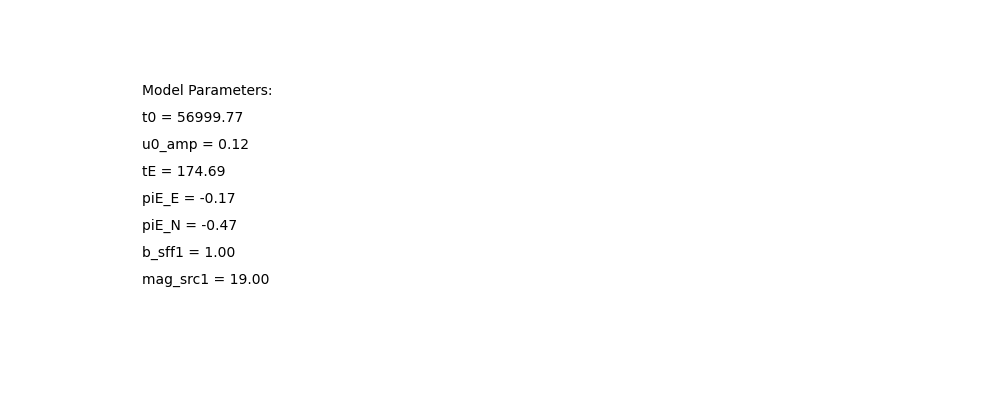

In [15]:
display(Image.open('fit_files/test_parameters.png').crop((0, 0, 1000, 400)))

## Residuals plot

A residuals plot shows the observed data points with the best fit model around the data points. A good residuals plot will be one that consistently goes through the observed data points.

You can see this file with `basename_phot_and_residuals_1.png`

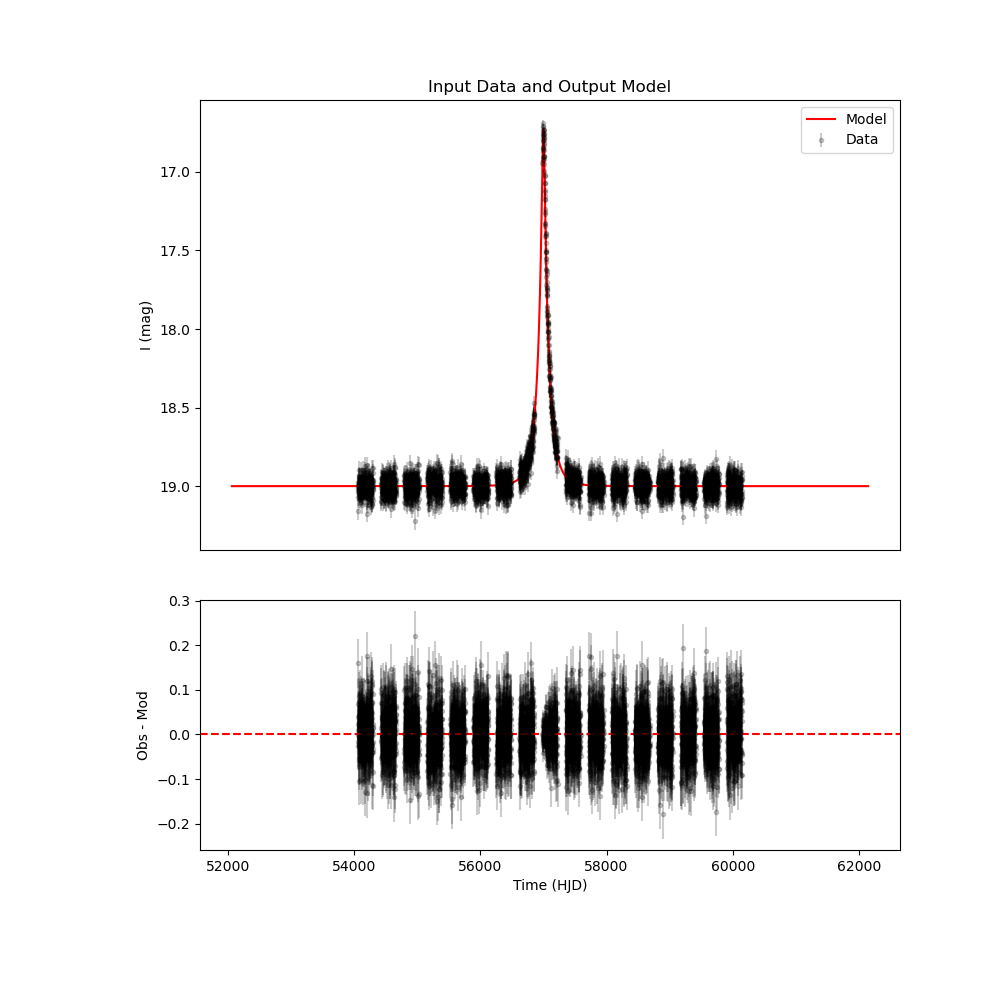

In [16]:
display(Image.open('fit_files/test_phot_and_residuals_1.png'))

<b>Top:</b> Shows data points, their errors, and the line of best fit for the observed data.

<b>Bottom:</b> Looks at the generic residuals plot, and subtracts the observed data point by the model it generates. These values are then plotted, with the x-axis staying constant from the generic residuals plot and the y-axis denoting the 'observed minus model'. This plot should be centered around 0, and major deviation with that questions the viability of the model.

## Corner and trace plots

To gain insight into how the parameters would fit and their possible relationship to one another, you will need to run a separate command to output the corner and trace plots. This is done through running `plot_dynesty_style()`. There are several optional arguments for this function, but the most notable is the `fit_vals` argument:

- fit_vals = [string; default=none]
  - mean
  - maxl (maximum likelihood)
    - Found by maximizing the likelihood function (probability density of observed data) 
  - map (maximum a posteriori)
    - Mode of the posterior distribution. This is a regularization of the maximum likelihood as it incorporates the prior distribution into the output quantity.
 
Adding this argument adds another line to your plots, which would signify as listed in the form of a red line. They would not affect the content of your corner and trace plots, only adding another line.

In [17]:
fitter.plot_dynesty_style(fit_vals='maxl')

The name of the trace and corner files are `basename_dy_trace.png` and `basename_dy_corner.png` respectively.

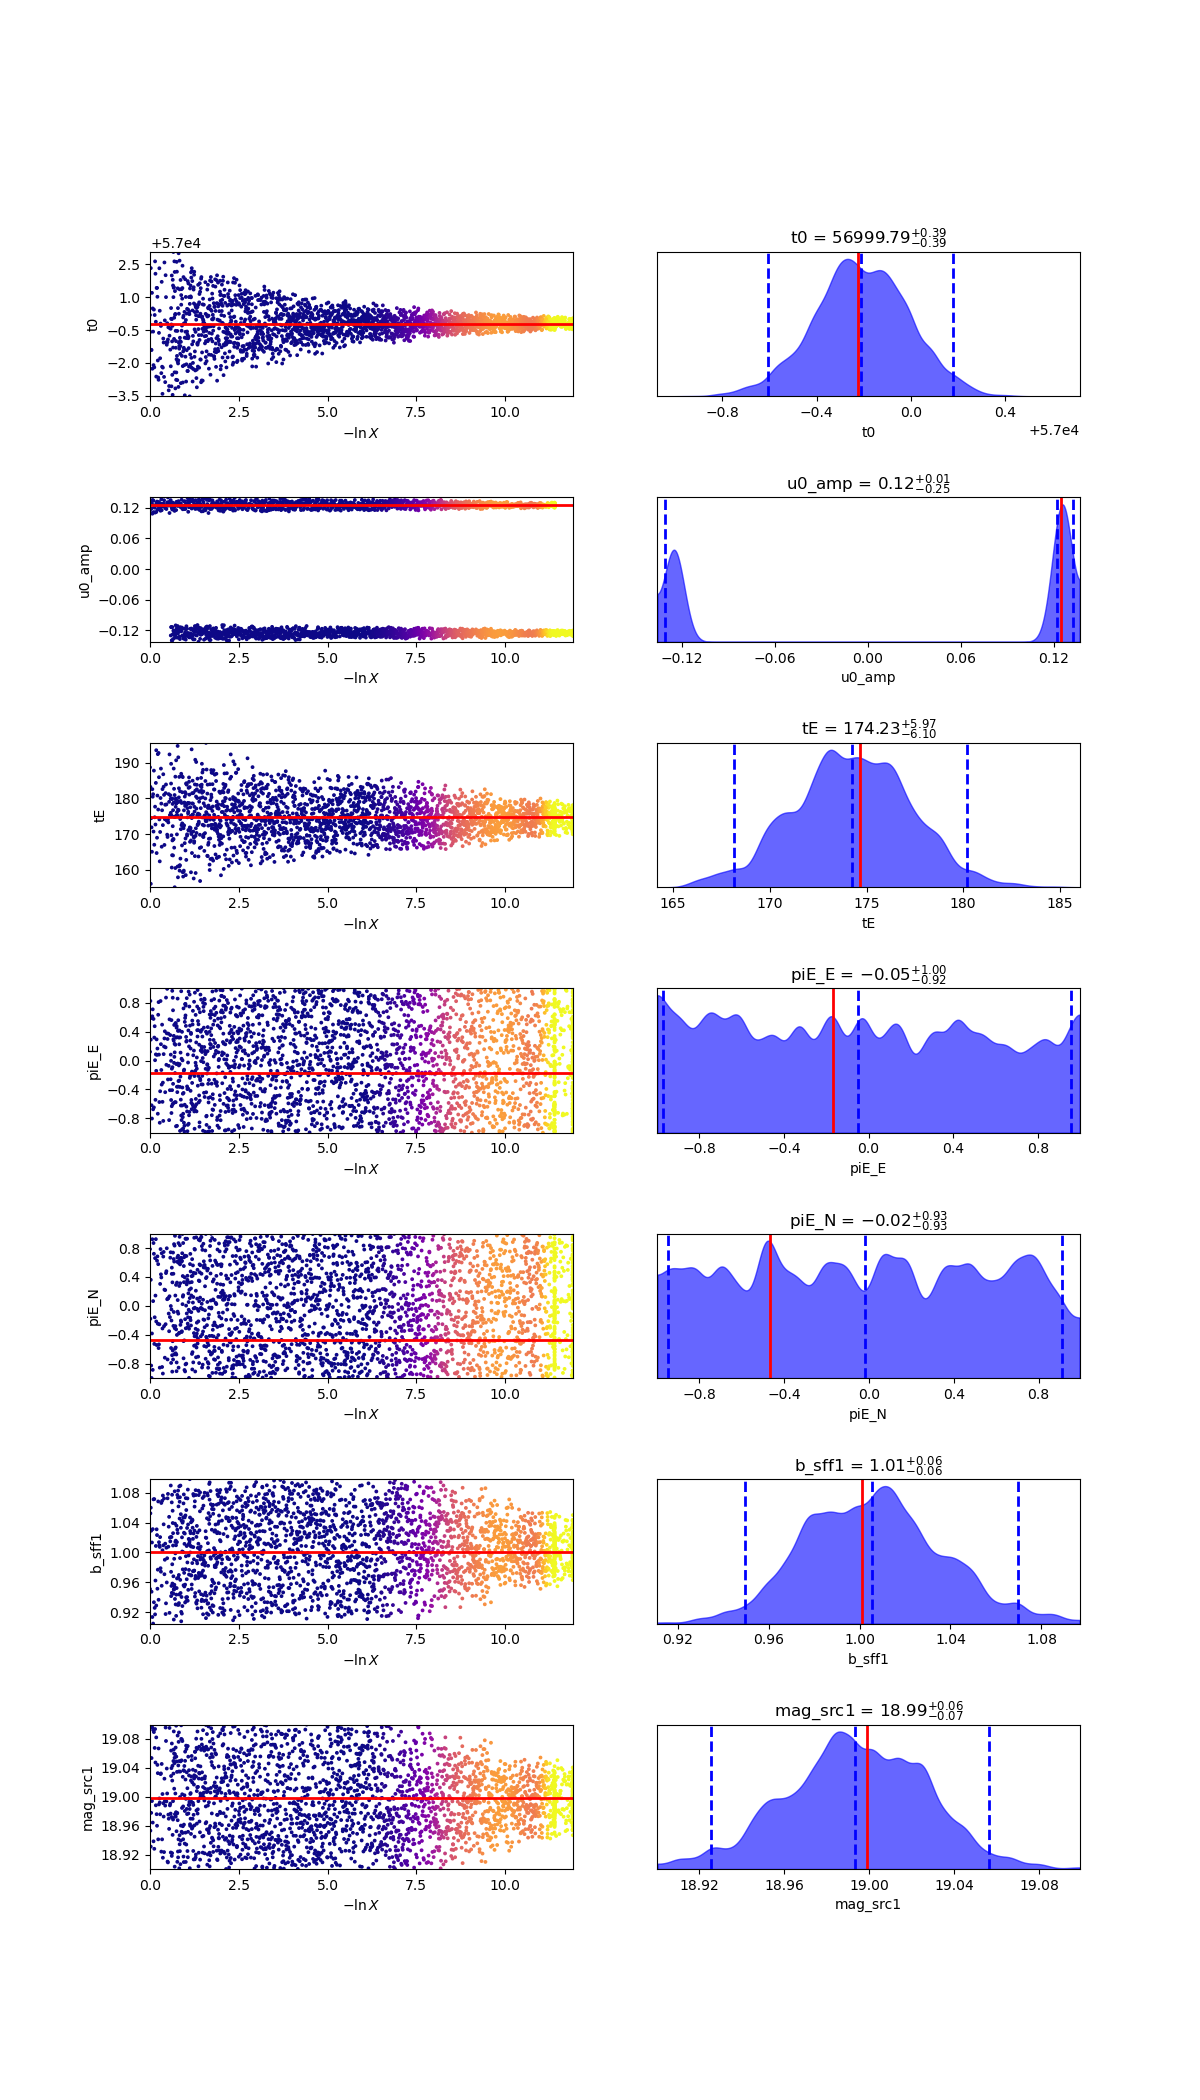

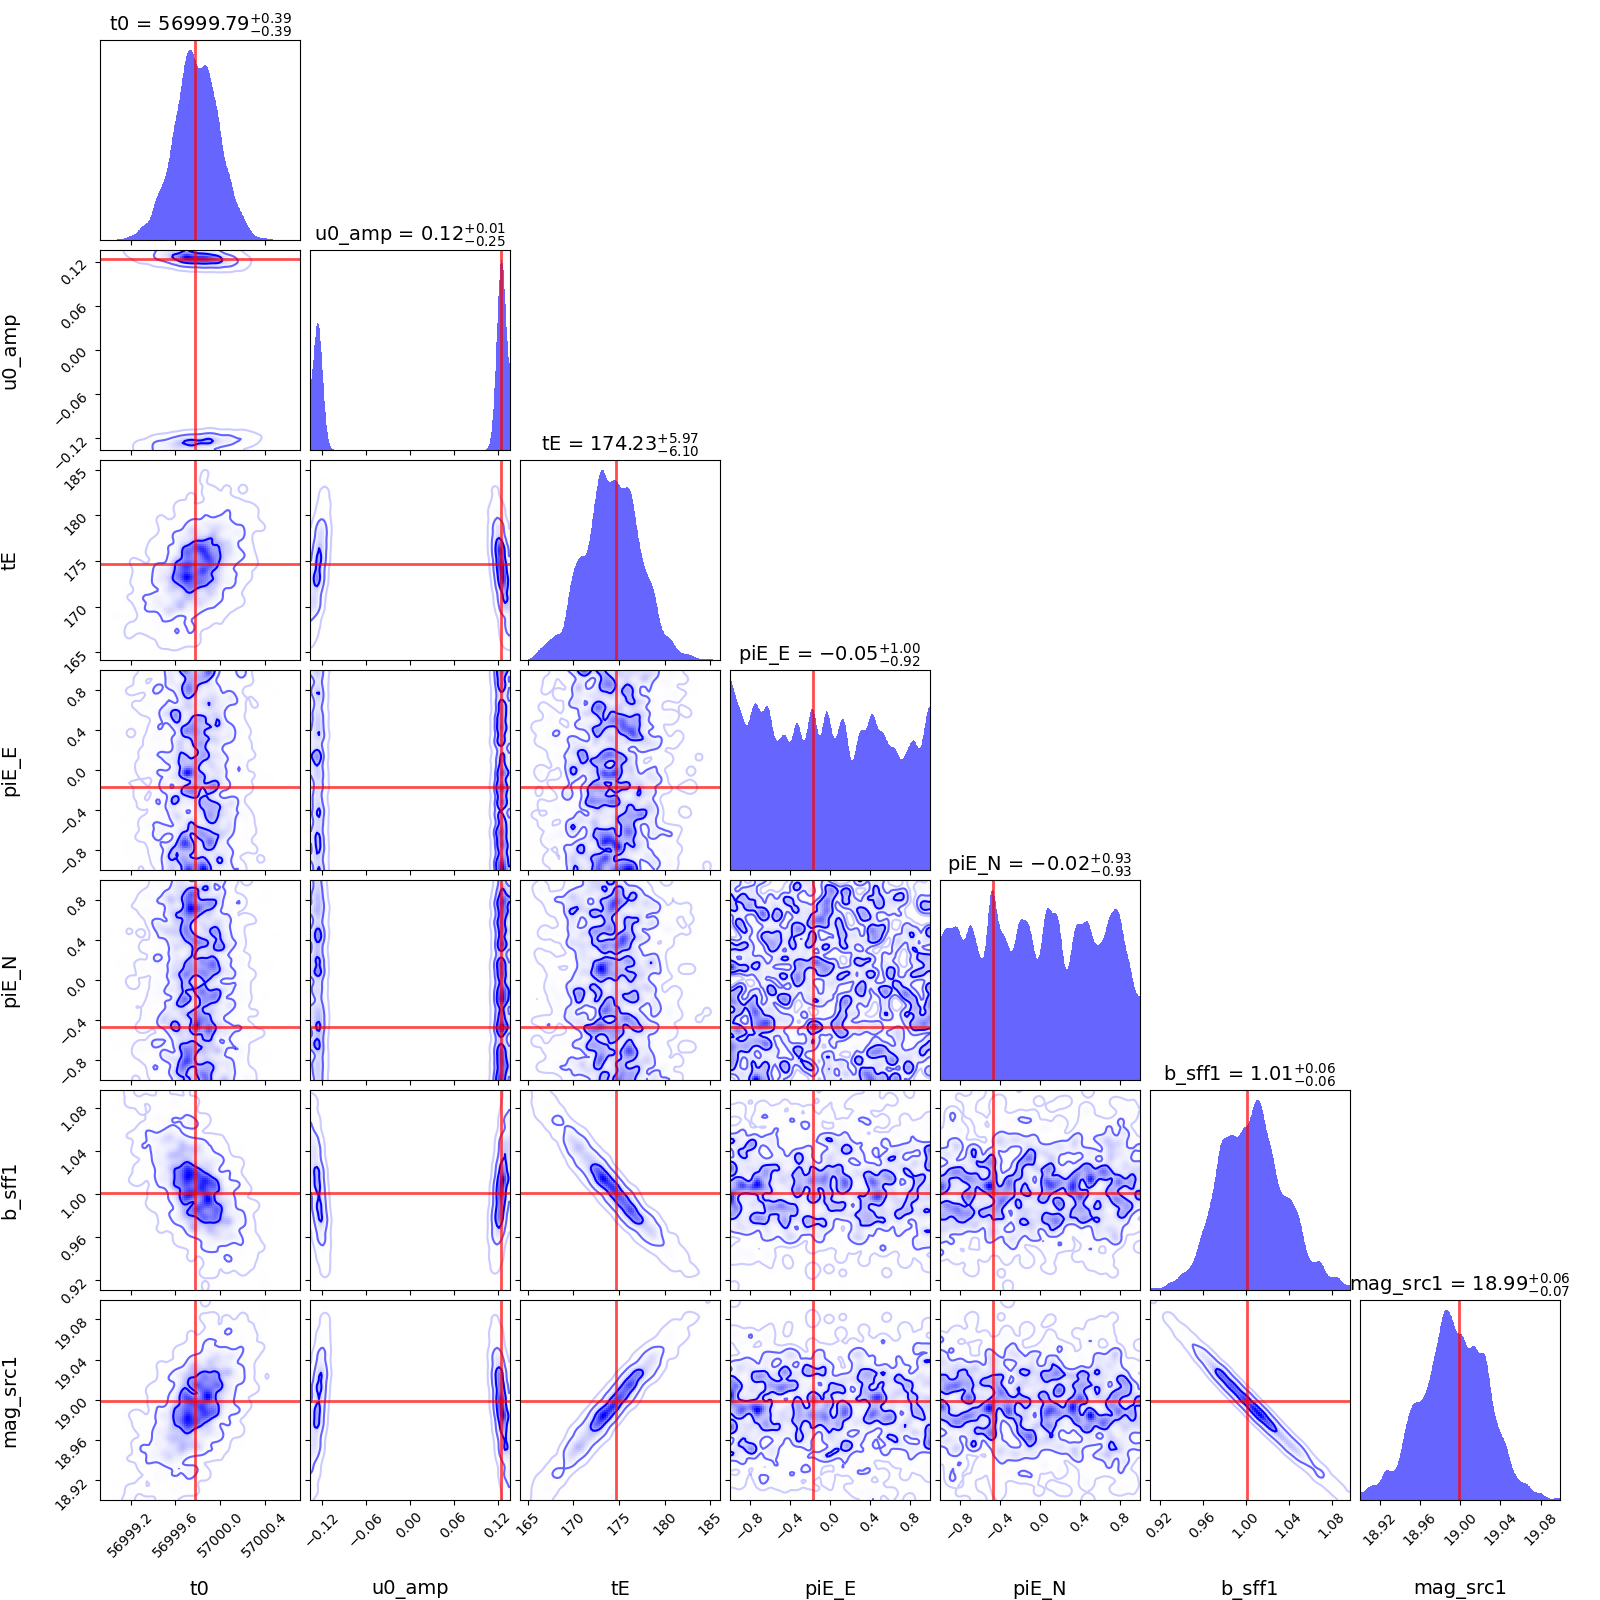

In [18]:
display(Image.open('fit_files/test_dy_trace.png'), Image.open('fit_files/test_dy_corner.png'))

<b>Top:</b> Trace plot: The trace plot shows two columns of plots, these plots are:

<i>Left:</i> Evolution of the sample particles as a function of ln(X). The color denotes the weighted importance. In other words, their relative posterior mass.

<i>Right:</i> The marginalized posteriors of the plotted particles graph to the left with a errors of the provided range.

<b>Bottom:</b> Corner plot: On the outside diagonal, these plots are the same 1D posterior distributions seen in the trace plot above. On the inside are the 2D posterior distributions showing the relationship with the two parameters that are aligned for that plot. The more circular or scattered the plot is, the less the two parameters are correlated to one another. The more diagonal and thin the plot is, the more the two parameters are correlated to one another.

In addition to these plots, you can also add a red line (discussed above) which notes each parameters' mean, maximum likelihood, or maximum a posteriori. These are added to the corner and trace plot. You can also get these values from looking into an output summary.fits:

In [19]:
summary=Table.read('fit_files/test_summary.fits')
summary

Mean_t0,Mean_u0_amp,Mean_tE,Mean_piE_E,Mean_piE_N,Mean_b_sff1,Mean_mag_src1,StDev_t0,StDev_u0_amp,StDev_tE,StDev_piE_E,StDev_piE_N,StDev_b_sff1,StDev_mag_src1,MaxLike_t0,MaxLike_u0_amp,MaxLike_tE,MaxLike_piE_E,MaxLike_piE_N,MaxLike_b_sff1,MaxLike_mag_src1,MAP_t0,MAP_u0_amp,MAP_tE,MAP_piE_E,MAP_piE_N,MAP_b_sff1,MAP_mag_src1,logZ,maxlogL
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
56999.78801008341,0.02442200037652731,174.23252727806786,-0.040525495461411126,-0.01859903867415558,1.006014424235754,18.993528183047577,0.15108813743857658,0.12306297144979281,3.0456302165546787,0.5826328574043527,0.5664028298769405,0.030356477998347453,0.03293316557785067,56999.77314209244,0.12469497221439574,174.68768349435572,-0.17011887251097613,-0.46659943948268323,1.000904372050547,18.998877522879457,56999.77314209244,0.12469497221439574,174.68768349435572,-0.17011887251097613,-0.46659943948268323,1.000904372050547,18.998877522879457,6284.642277207109,6305.9853472261075
56999.78193204399,0.1255071490788271,174.17075082466394,-0.054768330013465004,-0.035527250960051104,1.0067375073262284,18.992702145834663,0.19200818139764986,0.0035551334424770513,3.000126637836574,0.5879999104273135,0.5694325963647363,0.02989966381160773,0.03241323870395988,56999.77314209244,0.12469497221439574,174.68768349435572,-0.17011887251097613,-0.46659943948268323,1.000904372050547,18.998877522879457,56999.77314209244,0.12469497221439574,174.68768349435572,-0.17011887251097613,-0.46659943948268323,1.000904372050547,18.998877522879457,6284.358375537008,6305.9853472261075
56999.79700995843,-0.12526929427115166,174.3240085409008,-0.019434085190275403,0.006468996004494385,1.0049436512618926,18.994751414710628,0.21144100425132442,0.0036546418638433334,3.109538385154449,0.5739441454280838,0.5609486174377468,0.03098961844210224,0.033651204948025114,56999.736308953936,-0.1252185279994572,174.1553479992902,0.750436538062534,-0.32529404324050293,1.005827466910803,18.993485169462723,56999.736308953936,-0.1252185279994572,174.1553479992902,0.750436538062534,-0.32529404324050293,1.005827466910803,18.993485169462723,6283.965763617388,6305.90947081778


# Accuracy

One thing that is important is a numerical understanding in how accurate this fit is. To get the chi2 value, you can run the function `calc_chi2()`. You will need to divide this value by the degrees of freedom of the fit, which is just the sum of the data points in your array(s) + the number of parameters the fit can output.

<div class="alert alert-block alert-info">
    If you are unaware of the number of parameters your fit will output, you can check with <b> len(model_class.fitter_param_names)</b> Additionally, if you are using astrometry data, make sure to add the length of the t_ast1 array to your "data point" summation to have an accurate degree of freedom and chi2 value.
</div>

In [20]:
number_of_params=len(model.PSPL_Phot_noPar_Param1.fitter_param_names)
data_points=int(len(data['t_phot1'])) # + int(len(data['t_ast1'])) for PhotAstrom models
dof= data_points-number_of_params

chi2_raw=fitter.calc_chi2(params='best', verbose=False)
chi2=chi2_raw/dof

print('Raw chi2 value : ', chi2_raw, '\nActual chi2 value : ', chi2)

Raw chi2 value :  3906.983865001461 
Actual chi2 value :  0.9587690466261254


You can also see the raw chi2 values for the best fit parameters through the function `print_likelihood`

In [21]:
fitter.print_likelihood()

t0            = 56999.773142 
u0_amp        = 0.124695 
tE            = 174.687683 
piE_E         = -0.170119 
piE_N         = -0.466599 
b_sff1        = 1.000904 
mag_src1      = 18.998878 
lnL_phot      = 6305.985347 
lnL_ast       = 0.000000 
lnL           = 6305.985347 
chi2_phot1    = 3906.983865 
chi2_phot     = 3906.983865 
chi2_ast      = -0.000000 
chi2          = 3906.983865 
logL :           6306.0
chi2 :           3907.0


<div class="alert alert-block alert-warning">
    <b>Note:</b> The StDev values you can find in the <b>summary.fits</b> file are another way to analyze the accuracy of the fit by parameter as these values describe the errors on the posterior.
</div>

# Final notes

To conclude this tutorial, it is important to note the different information and parameters the model fitter will output given just photometry data or photometry and astrometry data (at least in the case with no parallax).

## *Photometry and Photometry-Astrometry output parameters comparisson*

| Parameter | Phot | PhotAstrom | Description | Units |
| --- | --- | --- | --- | --- |
| mL |  | X | Lens mass| m_sun
|t0| X | X | Time of photometric peak| MJD|
|beta|  | X | Angular distance between lens and source| mas|
|dL|  | X | Observer distance to lens|pc|
|dL_dS|  | X | Ratio of observer distance from lens vs source | n/a|
|XSO_E|  | X | Source at t0 in East direction|arcsec|
|XSO_N|  | X |Dec of source at t0 |arcsec|
|muL_E|  | X |RA lens proper motion |mas/yr|
|mUL_N |  | X |Dec lens proper motion |mas/yr|
|muS_E|  | X |RA source proper motion |mas/yr|
|muS_N |  | X |Dec source proper motion |mas/yr|
|b_sff1 | X | X | Ratio of source flux vs total |n/a|
|mag_src1| X | X | Source photometric magnitude|n/a|
|dS |  | X | Obsevrer disnace to source |pc|
|tE | X | X | Einstein crossing time|days|
|u0_amp| X | X |Distance apart between lens and source at t0|thetaE|
|thetaE_E|  | X |Einstein radius in relative proper motion in East direction|mas|
|thetaE_N|  | X |Einstein radius in relative proper motion in North direction|mas|
|piE_E| X | X |Microlensing parallax in East direction|thetaE|
|piE_N| X | X |Microlensing parallax in North Direction|thetaE|
|muRel_E|  | X |RA source-lens relative proper motion |mas/yr|
|muRel_N|  | X |Dec source-lens relative proper motion |mas/yr|

<div class="alert alert-block alert-info">
    <b>Take away:</b> When you only using photometry, you will have less output parameters than if you include astrometry data. Dimensionality = number of parameters output.
</div>

### Here is an example of using Astrometry with the same fake input data

<div class="alert alert-block alert-danger">
    <b>Warning:</b> Processing this fit with astrometry data takes around 2 minutes, so do not close out of the kernel while it runs or the fit will fail.
</div>

In [22]:
fitter_ast = model_fitter.PSPL_Solver(data,
                     model.PSPL_PhotAstrom_noPar_Param1,
                     n_live_points=200,
                     outputfiles_basename='astrom_test_files/photastrom_test_')

fitter_ast.priors['mL'] = model_fitter.make_gen(5.0, 15.0) #m_sun
fitter_ast.priors['t0'] = model_fitter.make_gen(56990, 57010) #MJD
fitter_ast.priors['beta'] = model_fitter.make_gen(-0.5, -0.3) #mas
fitter_ast.priors['muL_E'] = model_fitter.make_gen(-1, 1) #mas/yr
fitter_ast.priors['muL_N'] = model_fitter.make_gen(-8, -6) #mas/yr
fitter_ast.priors['muS_E'] = model_fitter.make_gen(0, 3) #mas/yr
fitter_ast.priors['muS_N'] = model_fitter.make_gen(-2, 1) #mas/yr
fitter_ast.priors['dL'] = model_fitter.make_gen(3000, 5000) #pc
fitter_ast.priors['dL_dS'] = model_fitter.make_gen(0.45, 0.55) #ratio; no units
fitter_ast.priors['b_sff1'] = model_fitter.make_gen(0.5, 1.1) #ratio; no units
fitter_ast.priors['mag_src1'] = model_fitter.make_gen(18.9, 19.1) #magnitude
fitter_ast.priors['xS0_E'] = model_fitter.make_gen(-10 ** -3, 10 ** -3) #arcsec
fitter_ast.priors['xS0_N'] = model_fitter.make_gen(-10 ** -3, 10 ** -3) #arcsec

fitter_ast.solve()
fitter_ast.plot_dynesty_style(fit_vals='maxl')

*************************************************
*** Using Prior for prior function. ***
*************************************************
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  200
 dimensionality =   13
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.976562
Replacements:                                250
Total Samples:                               256
Nested Sampling ln(Z):            -338441.213010
Acceptance Rate:                        0.911854
Replacements:                                300
Total Samples:                               329
Nested Sampling ln(Z):            -223424.452958
Acceptance Rate:                        0.857843
Replacements:                                350
Total Samples:                               408
N

Including astrometry data allows for more parameters to output, but also more plots. Some example of these plots are the `[basename]_astr_remove_pm_1.png`

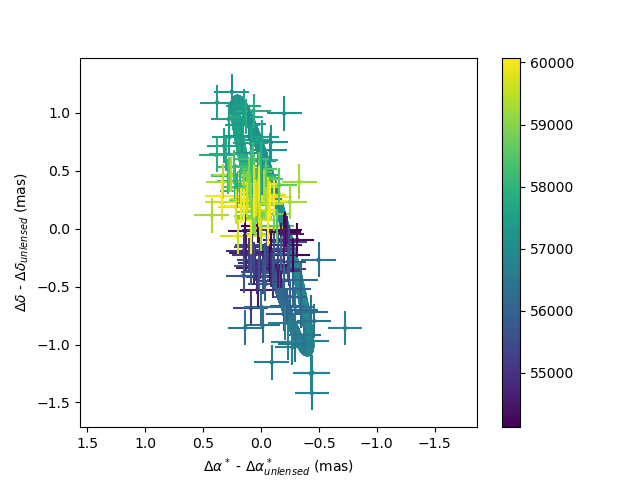

In [23]:
display(Image.open('astrom_test_files/photastrom_test_astr_remove_pm_1.png'))

This plot looks at astrometric shift without proper motion (hence 'remove_pm' in the image title) of the micorlensing event by change in dec (y-axis) and RA (x-axis). In understanding that the model we used is with no parallax, something that looks like a loop is to be expected. The color bar denotes the time of observation for the data in MJD.

Another new type of plot you'll see when adding astrometry data in your fitting run is `[basename]_astr_on_sky_1.png`

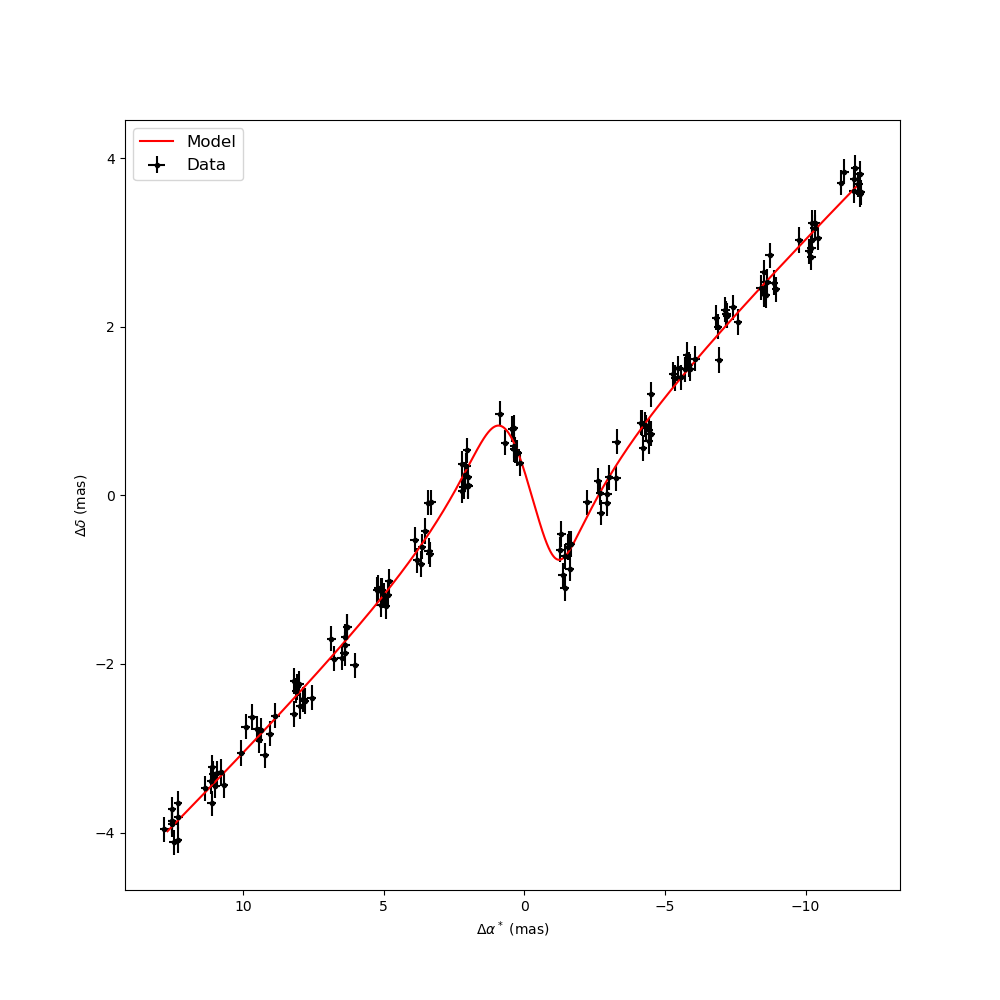

In [24]:
display(Image.open('astrom_test_files/photastrom_test_astr_on_sky_1.png'))

This plot is the astrometry plot without subtracting proper motion by dec (y-axis) and RA (x-axis). The wobble in the middle of the plot shows that the event analyzed is a microlensing event between two (or more) objects. A comparison, for example, is that when looking at a single star, this line will be generally straight across without the wobble in the middle. Keep in mind this is without parallax.

# Running alternatives
Running fits in a Jupyter notebook is highly advised against as Jupyter runs slowly and eats up RAM quickly. A work around is to put all your fit code into a .py file and run it with the code `python path/example_file.py`. Even with running it through python though, most fits will take hours to even weeks to run depending on the data, priors, or model. A way to make this work faster is to run your .py file faster is through multithreading. The code you will use to multithread is: `mpirun -np -4 python path/example_file.py` where the 4 represents the number of threads you are using. It does not exactly have to be 4, this was just used as an example. 